In [1]:
# imports
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore, spearmanr # for plotting
import seaborn as sns # for plotting
from torchvision.models.feature_extraction import create_feature_extractor

device = 'cpu' # mps out of memory

In [2]:
# load two models for comparison
from torchvision.models import resnet18, googlenet, ResNet18_Weights, GoogLeNet_Weights

# resnet18
rw = ResNet18_Weights.DEFAULT
preprocess = rw.transforms() # for data preprocessing (same for both models (both ImageNet))
rw = resnet18(weights=rw).eval()
rf = create_feature_extractor(rw, {'avgpool': 'pen_feat'}) # avgpool is penultimate layer

# googlenet
gw = GoogLeNet_Weights.DEFAULT
gw = googlenet(weights=gw).eval()
gf = create_feature_extractor(gw, {'avgpool': 'pen_feat'}) # avgpool is penultimate layer

In [3]:
# preprocess data
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess
])

# load dataset for stimuli
data = datasets.MNIST(
    root = './data',
    train = False,
    download=True,
    transform=preprocess
)

# select 3 examples per digit (0-9) (from gemini)
torch.manual_seed(1337)
def sample_per_digit(dataset, n_samples):    
    indices_by_digit = [torch.where(dataset.targets == i)[0] for i in range(10)]
    selected_indices = torch.cat([
    digit_indices[torch.randperm(len(digit_indices))[:n_samples]]
    for digit_indices in indices_by_digit
    ])
    images = [dataset[i][0] for i in selected_indices]
    labels = [dataset[i][1] for i in selected_indices]
    return torch.stack(images), torch.tensor(labels)

images_tensor, labels_tensor = sample_per_digit(data, 3)
n_samples = len(images_tensor)

In [4]:
# get activations from each model
r_act = rf(images_tensor)['pen_feat']
g_act = gf(images_tensor)['pen_feat']

In [5]:
activations = {
    'resnet': r_act.view(n_samples,512).detach(),
    'googlenet': g_act.view(n_samples,1024).detach()
}

In [6]:
# build RDMs via euclidean distance

# example with two stimuli
x = activations['resnet'][0]
y = activations['resnet'][1]

d_xy = torch.sqrt(torch.dot(x-y,x-y))
print(d_xy)

tensor(10.1938)


In [7]:
# now for all stimuli! (in matmul form)
def rdm(activations):
    A = torch.sum(torch.square(activations), dim=1, keepdim=True)
    rdm_sq = A + A.T - 2*torch.mm(activations,activations.T)
    return torch.sqrt(rdm_sq)

In [8]:
rdm_rn, rdm_gn = rdm(activations['resnet']), rdm(activations['googlenet'])
rdms = {
    'resnet' : rdm_rn,
    'googlenet': rdm_gn
}

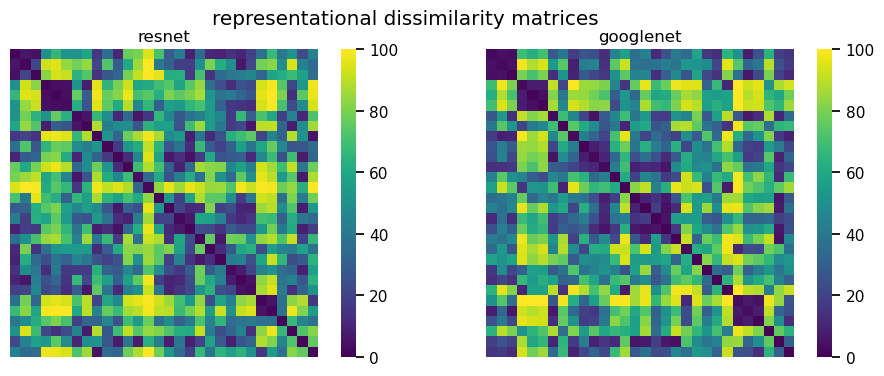

In [9]:
# plotting the rdms (mostly from Marvin Theiss)

# get percentiles for plotting
percentile_rdms = {}
for model in ['resnet', 'googlenet']:
    raw_rdm = rdms[model]
    raw_rdm = torch.nan_to_num(raw_rdm, nan=0.0)
    percentiles = percentileofscore(raw_rdm.flatten().detach().numpy(), raw_rdm.flatten().detach().numpy(), kind='rank')    
    percentile_rdms[model] = percentiles.reshape(raw_rdm.shape)

# prepare plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# plot rdms
with sns.plotting_context('notebook'):
    for ax, model in zip(axes, ['resnet', 'googlenet']):
        sns.heatmap(
            percentile_rdms[model],
            vmin=0,
            vmax=100,
            cmap='viridis',
            cbar=True,
            square=True,
            ax=ax
        )
        ax.set_title(model)
        ax.set_xticks([])
        ax.set_yticks([])

    # Add title
    fig.suptitle('representational dissimilarity matrices')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [10]:
# compute similarity between rdms
indices_above = np.triu_indices_from(rdms['resnet'], k=1)

rdms_flattened = {
    'resnet': rdms['resnet'][indices_above],
    'googlenet': rdms['googlenet'][indices_above]
}
# euclidean
d_r_g = torch.sqrt(torch.dot(rdms_flattened['resnet'] - rdms_flattened['googlenet'], rdms_flattened['resnet'] - rdms_flattened['googlenet']))

# 1 - spearman correlation
sp_r_g = 1 - spearmanr(rdms_flattened['resnet'],rdms_flattened['googlenet']).statistic
cor = [[0, sp_r_g], [sp_r_g, 0]]

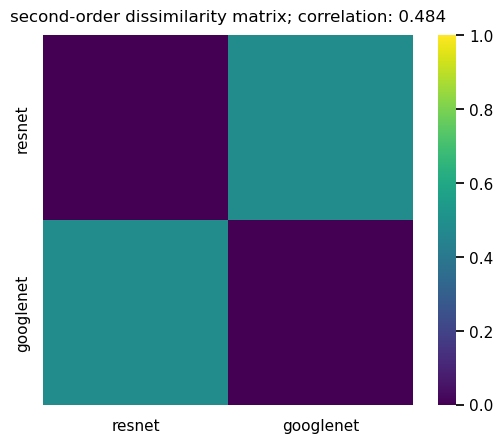

In [11]:
# plot (a bit unnecessary for two models, but still)
with sns.plotting_context('notebook'):
    ax = sns.heatmap(
        cor,
        vmin=0,
        vmax=1,
        cmap='viridis',
        cbar=True,
        square=True
    )

    ax.set_title(f'second-order dissimilarity matrix; correlation: {sp_r_g:.3f}', pad=10)
    ax.tick_params(left=False, bottom=False)
    ax.set_xticklabels(rdms.keys())
    ax.set_yticklabels(rdms.keys())
    
    plt.show()